# Neural & Behavioral Modeling - Week 11 (Exercises)
by 黃翔易 (b08303047@ntu.edu.tw)

In [1]:
%config IPCompleter.greedy=True 
%matplotlib inline
from matplotlib.pyplot import *
from IPython.display import *
import numpy as np

In [2]:
# Check GPU status:
import torch as t
print('PyTorch version:',t.__version__)
use_cuda=t.cuda.is_available()
if(use_cuda):
    for i in range(t.cuda.device_count()):
        print('Device ',i,':',t.cuda.get_device_name(i))
    print('Current: Device ',t.cuda.current_device())
    t.backends.cudnn.benchmark = True 
    device = t.device("cuda")
else:
    device = t.device("cpu")
    print('No GPU')

PyTorch version: 1.12.1+cu113
Device  0 : Tesla T4
Current: Device  0


## 1 Fair Performance Evaluation (2 points)
We often compare and assess performances of different model architectures/parameters/hyperparameters. Note that the results are differnt even if you re-run exactly the same code block. This is primarily due to a non-fixed random number seed. Please:

(1) run the section 1.2 TEN times and report (a) min, (b) max, (c) mean, & (d) standard deviation of the TESTING accuracies. (2 points)

(2) try to fix the random number seeds in numpy & pytorch to see if you can obtain the same results every time in the section 1.2. (2 points)

### 1.0 CIFAR-10 dataset

In [3]:
# Load the dataset:
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
train_set = CIFAR10(root='.', train=True, transform=transforms.ToTensor(), download = True)
train_data = t.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_set = CIFAR10(root='.', train=False, transform=transforms.ToTensor(), download = True)
test_data = t.utils.data.DataLoader(train_set, batch_size=1000, shuffle=True)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


### 1.1 The model

In [4]:
# Make the model:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__() # = nn.Module.__init__(self)
        self.conv1 = nn.Conv2d(3, 6, 5) # in, out, kernel
        self.conv2 = nn.Conv2d(6, 16, 5) 
        self.fc1   = nn.Linear(16*5*5, 120) 
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)
    def forward(self, x): # functional expressions
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) 
        x = x.view(x.size()[0], -1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)        
        return x
lenet = Net()
lenet = lenet.to(device)
loss_fn = t.nn.CrossEntropyLoss()
optimizer = t.optim.Adam(lenet.parameters())

### 1.2 Training & Testing

In [5]:
# run ten times:
accuracy = []
for _ in range(10):
  # Training:
  for e in range(2):
    for i, (X_train, Y_train) in enumerate(train_data, 0):
        X_train,Y_train=X_train.to(device),Y_train.to(device)
        Y_pred = lenet(X_train)
        loss = loss_fn(Y_pred, Y_train)
        lenet.zero_grad()
        loss.backward()
        optimizer.step()   
        Y_pred = lenet(X_train)
        Y_pred = t.max(Y_pred,1)[1]
     #print('epoch ',e,':',(Y_pred==Y_train).sum().item()/Y_train.shape[0])
    
    # Testing on a batch:
    dataiter = iter(test_data)
    X_test, Y_test = dataiter.next() # returning a batch
    X_test,Y_test=X_test.to(device),Y_test.to(device)

    with t.no_grad():
        Y_pred = lenet(X_test)
        Y_pred = t.max(Y_pred,1)[1]
        test = (Y_pred==Y_test).sum().item()/Y_test.shape[0]
        print('test :', test)
        accuracy.append(test)

test : 0.515
test : 0.571
test : 0.612
test : 0.659
test : 0.644
test : 0.677
test : 0.721
test : 0.717
test : 0.717
test : 0.749


### 1.3 Your answers

In [6]:
# (1) calculate min, max, mean, standard deviation:
min_accuracy = min(accuracy)
max_accuracy = max(accuracy)
mean = sum(accuracy) / len(accuracy)
std = np.std(accuracy)

print('min = ', min_accuracy)
print('max = ', max_accuracy)
print('mean = ', mean)
print('std = ', std)

min =  0.515
max =  0.749
mean =  0.6581999999999999
std =  0.07064248013766221


In [7]:
# (2) fix the random number:
import random

new_accuracy = []
seed = 1705
for _ in range(10):
    # Seed
    t.manual_seed(seed)
    t.cuda.manual_seed(seed)
    t.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    t.backends.cudnn.benchmark = False
    t.backends.cudnn.deterministic = True

    # Training:
    lenet = Net()
    lenet = lenet.to(device)
    # loss_fn = t.nn.CrossEntropyLoss()
    optimizer = t.optim.Adam(lenet.parameters())

    for e in range(2):  
        for i, (X_train, Y_train) in enumerate(train_data, 0):
            X_train,Y_train=X_train.to(device),Y_train.to(device)
            Y_pred = lenet(X_train)
            loss = loss_fn(Y_pred, Y_train)
            lenet.zero_grad()
            loss.backward()
            optimizer.step()   
            Y_pred = lenet(X_train)
            Y_pred = t.max(Y_pred,1)[1]
        # print('epoch ',e,':',(Y_pred==Y_train).sum().item()/Y_train.shape[0])
  
    # Testing on a batch:
    dataiter = iter(test_data)
    X_test, Y_test = dataiter.next() # returning a batch
    X_test,Y_test=X_test.to(device),Y_test.to(device)
  
    with t.no_grad():
        Y_pred = lenet(X_test)
        Y_pred = t.max(Y_pred,1)[1]
        test = (Y_pred==Y_test).sum().item()/Y_test.shape[0]
        print('test :', test)
        new_accuracy.append(test)

test : 0.484
test : 0.484
test : 0.484
test : 0.484
test : 0.484
test : 0.484
test : 0.484
test : 0.484
test : 0.484
test : 0.484


### 討論：
1. 關鍵點在於兩個：
  * 需要將 seed 放在迴圈之中。
  * lenet 需要初始化。
2. 但最大的問題點在於，將 DataLoader 設定 shuffle = True，會使得每次的訓練資料與測試資料都不相同，但最後的結果居然都會是相同的。這很神奇。

## 2 Universal Approximation Theorem (4 points)

Please FAIRLY evaluate whether a deep network learns XOR more efficiently than a shallow network with the same number of model parameters. Please discuss why in either case.

### 2.0 XOR data

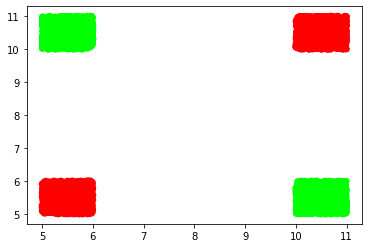

In [8]:
N=1000 # samples per cluster
XY=t.tensor([[5,5],[5,10],[10,5],[10,10]],dtype=t.float32) # 4 cluster centers
Z=t.tensor([0,1,1,0]) # category labels
t.cat([t.randn(2,1)+XY[0,0],t.randn(2,1)+XY[0,1]],1)
xy,z=t.zeros(4*N,2),t.zeros(4*N,dtype=t.int64)
for i in range(4):
    xy[i*N:(i+1)*N,]=t.rand(N,2)+XY[i,]
    z[i*N:(i+1)*N]=Z[i]
xy_np=xy.numpy()
z_np=z.numpy().astype(int)
cmap=np.array([[1,0,0],[0,1,0]])
scatter(xy_np[:,0],xy_np[:,1],color=cmap[z_np]);

#### 2.1 A shallow net with one hidden layer

In [23]:
# Number of free parameters: 2*H+H*2=48
shallow_acc = []
for _ in range(100):
    H=12 # number of hidden units
    model = t.nn.Sequential(
        t.nn.Linear(2, H, bias=False),
        t.nn.BatchNorm1d(H),
        t.nn.ReLU(),
        t.nn.Linear(H, 2, bias=False),
        t.nn.Softmax(dim=1)
    )
    loss_fn = t.nn.CrossEntropyLoss()
    optimizer = t.optim.Adam(model.parameters())

    for i in range(100):
        z_pred = model(xy)
        loss = loss_fn(z_pred,z)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        z_pred = model(xy) 
        z_pred = t.max(z_pred,1)[1]
        acc = (z_pred==z).sum().item()/xy.shape[0]
        # print('epoch ',i,':',(z_pred==z).sum().item()/xy.shape[0])
    shallow_acc.append(acc)
    
print(max(shallow_acc), min(shallow_acc), np.mean(shallow_acc), np.std(shallow_acc))

1.0 0.5 0.9452475000000001 0.10509167720971056


#### 2.2 A "deep" net with three hidden layers

In [24]:
# Number of free parameters: 2*H+H*H+H*H+H*2=48
deep_acc = []
for _ in range(100):
    H=4 # number of hidden units
    model = t.nn.Sequential(
        t.nn.Linear(2, H, bias=False),
        t.nn.BatchNorm1d(H),
        t.nn.ReLU(),
        t.nn.Linear(H, H,bias=False),
        t.nn.BatchNorm1d(H),
        t.nn.ReLU(),
        t.nn.Linear(H, H, bias=False),
        t.nn.BatchNorm1d(H),
        t.nn.ReLU(),
        t.nn.Linear(H, 2, bias=False),
        t.nn.Softmax(dim=1)
    )
    loss_fn = t.nn.CrossEntropyLoss()
    optimizer = t.optim.Adam(model.parameters())

    for i in range(100):
        z_pred = model(xy)
        loss = loss_fn(z_pred,z)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        z_pred = model(xy) 
        z_pred = t.max(z_pred,1)[1]
        acc = (z_pred==z).sum().item()/xy.shape[0]
        # print('epoch ',i,':',(z_pred==z).sum().item()/xy.shape[0])
    deep_acc.append(acc)
    
print(max(deep_acc), min(deep_acc), np.mean(deep_acc), np.std(deep_acc))

1.0 0.5 0.877135 0.13266888020557044


### 2.3 Your answers

1. 將 deep network 的 H 調大以後，正確率可以達到 100%。
2. 在 free parameters 的數量皆為 48 時，將淺層網路與深層網路都各跑一百次，淺層網路的正確率平均為 94.52%，深層網路的正確率平均為 87.71%，且深層網路的標準差比較大。整體來說，淺層網路的表現比較好。
3. 造成這樣的結果，有以下幾個可能原因：
  * 最主要的原因就是這裡所使用的資料量不夠大，且只有兩種分類，但越複雜的網路就需要有更大的資料量，故，使用深層網路來學習較容易造成 overfitting。像是複雜的模型就比較有可能對於 outliers 去做過度的學習。
  * 另外，過多層數也可能會造成梯度消失的問題。
  * 簡單來說，越複雜的網路可以學得越廣，但不代表能學得更一般化（像是死背答案那樣）。因此，若測試資料出現在深層網路沒學到的地方，則深層網路會無法變通，反而造成正確率下降。
4. 至於，要如何評估資料的複雜程度，也許在研究一開始都能先試著用淺層網路來測試看看。
5. 結論：需端看不同的資料集而使用相對應的模型。